# FOR RESTNET

In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Configurations
BATCH_SIZE = 64
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
IMG_SIZE = 224

In [3]:
# Custom Dataset
class MalariaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for label, class_dir in enumerate(["Uninfected", "Parasitized"]):
            class_path = os.path.join(root_dir, class_dir)
            for img_name in os.listdir(class_path):
                if img_name.endswith(".png"):
                    self.images.append(os.path.join(class_path, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
from collections import Counter
from prettytable import PrettyTable  
import random


dataset = MalariaDataset(root_dir="/kaggle/input/cell-images-for-detecting-malaria/cell_images/")

# Print total images
print(f"📊 Total images in dataset: {len(dataset)}\n")

# Show a sample of image paths and labels
sample_indices = random.sample(range(len(dataset)), 10)  # Random 10 samples

# Use PrettyTable for a nice format (optional)
try:
    table = PrettyTable()
    table.field_names = ["Index", "Label", "Class", "Image Path"]
    for idx in sample_indices:
        label = dataset.labels[idx]
        class_name = "Uninfected" if label == 0 else "Parasitized"
        path = os.path.basename(dataset.images[idx])  # Just show filename, not full path
        table.add_row([idx, label, class_name, path])
    print("🖼️ Sample Dataset Entries:\n")
    print(table)
except ImportError:
    print("Sample Dataset Entries:")
    for idx in sample_indices:
        label = dataset.labels[idx]
        class_name = "Uninfected" if label == 0 else "Parasitized"
        path = os.path.basename(dataset.images[idx])
        print(f"{idx}: Label={label} ({class_name}), File={path}")

# Label Distribution
label_counts = Counter(dataset.labels)
print("\n📈 Label Distribution:")
print(f" - 🧪 Uninfected (label=0): {label_counts[0]}")
print(f" - 🦠 Parasitized (label=1): {label_counts[1]}")

📊 Total images in dataset: 27558

🖼️ Sample Dataset Entries:

+-------+-------+-------------+------------------------------------------------+
| Index | Label |    Class    |                   Image Path                   |
+-------+-------+-------------+------------------------------------------------+
| 15081 |   1   | Parasitized |  C97P58ThinF_IMG_20150917_151512_cell_173.png  |
| 15606 |   1   | Parasitized | C129P90ThinF_IMG_20151004_133329_cell_101.png  |
|  7034 |   0   |  Uninfected |   C240ThinF_IMG_20151127_115306_cell_172.png   |
| 14327 |   1   | Parasitized | C118P79ThinF_IMG_20151002_105125_cell_160.png  |
|  683  |   0   |  Uninfected | C180P141NThinF_IMG_20151201_163702_cell_77.png |
| 11354 |   0   |  Uninfected | C180P141NThinF_IMG_20151201_163702_cell_1.png  |
| 18565 |   1   | Parasitized | C107P68ThinF_IMG_20150924_221909_cell_157.png  |
| 16762 |   1   | Parasitized |   C97P58ThinF_IMG_20150917_152437_cell_9.png   |
| 21513 |   1   | Parasitized | C189P150ThinF_I

In [7]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:

from torch.utils.data import Subset

# Step 1: Create full dataset
root_dir = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/"
dataset = MalariaDataset(root_dir=root_dir, transform=transform)

# Step 2: Split into train (80%) and temp (20%)
indices = list(range(len(dataset)))
labels = dataset.labels
train_idx, temp_idx = train_test_split(indices, test_size=0.2, stratify=labels, random_state=42)

# Step 3: Split temp into val (10%) and test (10%)
temp_labels = [labels[i] for i in temp_idx]
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=temp_labels, random_state=42)

# Step 4: Create subsets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Step 5: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


📸 Sample training images:


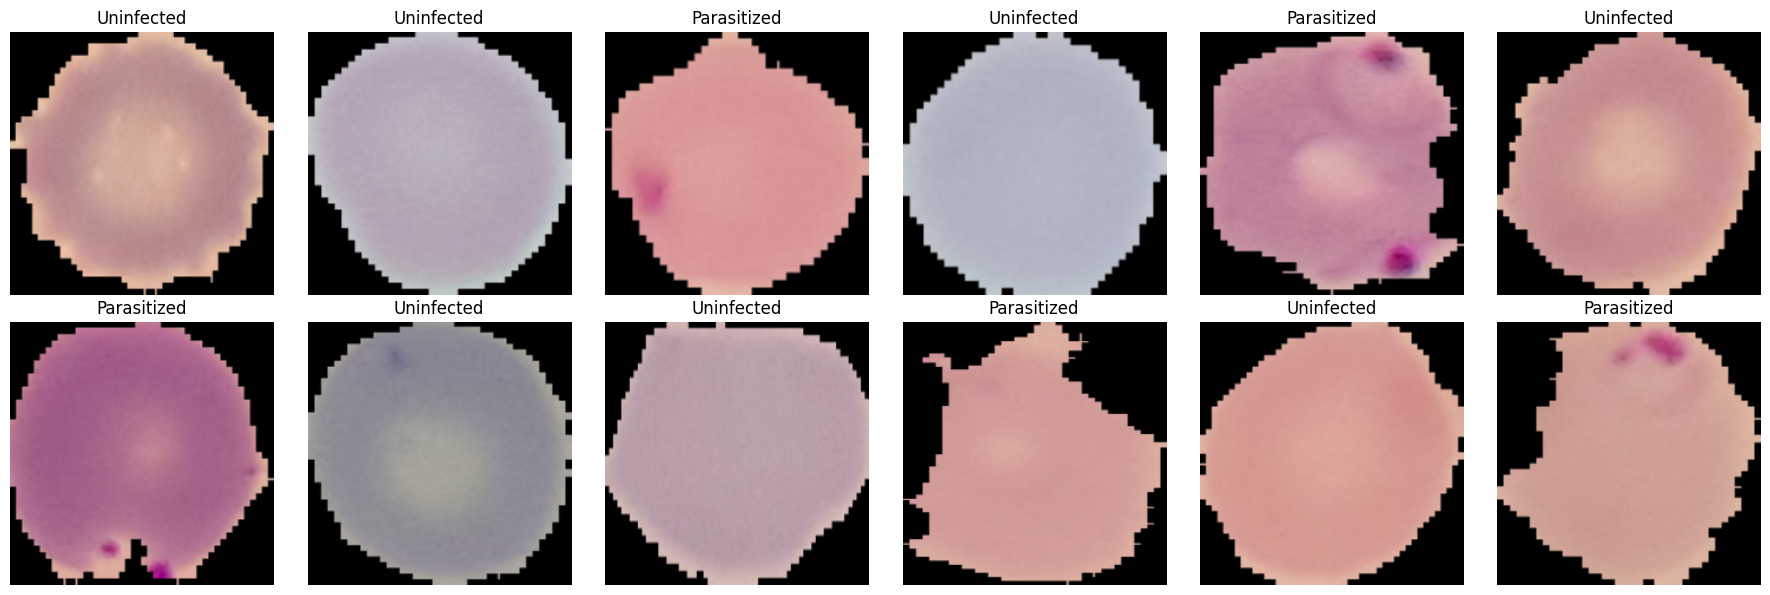

In [14]:
def show_samples(dataset, num_samples=12):
    class_names = ['Uninfected', 'Parasitized']  # Define class names
    
    # Determine grid size (2 rows, 6 columns)
    num_rows = 2
    num_cols = num_samples // num_rows
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))  # Make it larger
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for ax, idx in zip(axes.flatten(), indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image.numpy() * std + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title(f"{class_names[label]}", fontsize=12)
        ax.axis("off")
        
    plt.tight_layout()
    plt.show()

print("📸 Sample training images:")
show_samples(train_dataset)


In [15]:
# Load pretrained ResNet18
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


In [16]:
# Replace the classifier head
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2)
)


In [17]:
# Train on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [18]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)

In [19]:

import copy

NUM_EPOCHS = 50
patience = 5
best_val_acc = 0.0
patience_counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

train_acc, val_acc = [], []
for epoch in range(NUM_EPOCHS):
    model.train()
    correct, total = 0, 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    train_acc.append(acc)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    val_acc.append(acc)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Acc: {train_acc[-1]:.2f}%, Val Acc: {val_acc[-1]:.2f}%")

    # Early Stopping Logic
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        best_model_wts = copy.deepcopy(model.state_dict())
        patience_counter = 0  # Reset counter if validation improves
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model weights
model.load_state_dict(best_model_wts)
print(f"Training complete. Best Validation Accuracy: {best_val_acc:.2f}%")


100%|██████████| 345/345 [04:15<00:00,  1.35it/s]


Epoch [1/50], Train Acc: 88.04%, Val Acc: 89.88%


100%|██████████| 345/345 [01:28<00:00,  3.89it/s]


Epoch [2/50], Train Acc: 90.08%, Val Acc: 91.76%


100%|██████████| 345/345 [01:29<00:00,  3.88it/s]


Epoch [3/50], Train Acc: 91.11%, Val Acc: 91.62%


100%|██████████| 345/345 [01:29<00:00,  3.87it/s]


Epoch [4/50], Train Acc: 91.15%, Val Acc: 92.02%


100%|██████████| 345/345 [01:30<00:00,  3.80it/s]


Epoch [5/50], Train Acc: 91.52%, Val Acc: 92.38%


100%|██████████| 345/345 [01:29<00:00,  3.85it/s]


Epoch [6/50], Train Acc: 91.79%, Val Acc: 92.05%


100%|██████████| 345/345 [01:30<00:00,  3.80it/s]


Epoch [7/50], Train Acc: 91.92%, Val Acc: 92.60%


100%|██████████| 345/345 [01:30<00:00,  3.80it/s]


Epoch [8/50], Train Acc: 91.88%, Val Acc: 92.60%


100%|██████████| 345/345 [01:29<00:00,  3.84it/s]


Epoch [9/50], Train Acc: 92.08%, Val Acc: 92.71%


100%|██████████| 345/345 [01:29<00:00,  3.87it/s]


Epoch [10/50], Train Acc: 92.23%, Val Acc: 92.85%


100%|██████████| 345/345 [01:29<00:00,  3.83it/s]


Epoch [11/50], Train Acc: 92.46%, Val Acc: 92.53%


100%|██████████| 345/345 [01:32<00:00,  3.74it/s]


Epoch [12/50], Train Acc: 92.45%, Val Acc: 93.36%


100%|██████████| 345/345 [01:30<00:00,  3.79it/s]


Epoch [13/50], Train Acc: 92.64%, Val Acc: 92.67%


100%|██████████| 345/345 [01:30<00:00,  3.81it/s]


Epoch [14/50], Train Acc: 92.44%, Val Acc: 91.73%


100%|██████████| 345/345 [01:30<00:00,  3.83it/s]


Epoch [15/50], Train Acc: 92.67%, Val Acc: 93.11%


100%|██████████| 345/345 [01:29<00:00,  3.84it/s]


Epoch [16/50], Train Acc: 92.46%, Val Acc: 93.40%


100%|██████████| 345/345 [01:30<00:00,  3.80it/s]


Epoch [17/50], Train Acc: 92.86%, Val Acc: 92.56%


100%|██████████| 345/345 [01:28<00:00,  3.88it/s]


Epoch [18/50], Train Acc: 92.98%, Val Acc: 92.74%


100%|██████████| 345/345 [01:30<00:00,  3.83it/s]


Epoch [19/50], Train Acc: 93.02%, Val Acc: 93.32%


100%|██████████| 345/345 [01:30<00:00,  3.82it/s]


Epoch [20/50], Train Acc: 93.17%, Val Acc: 92.45%


100%|██████████| 345/345 [01:31<00:00,  3.78it/s]


Epoch [21/50], Train Acc: 93.19%, Val Acc: 93.36%
Early stopping at epoch 21
Training complete. Best Validation Accuracy: 93.40%


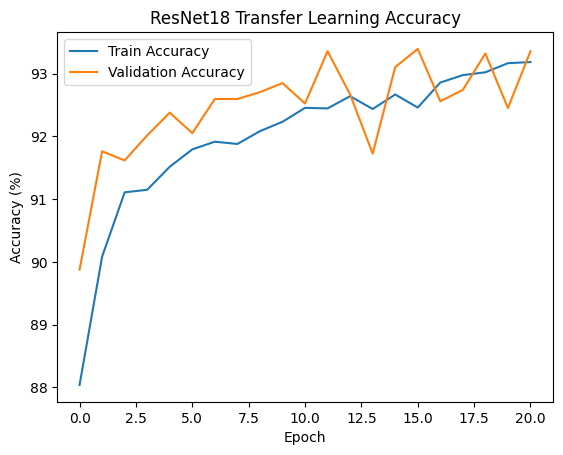

In [20]:
# Plotting
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("ResNet18 Transfer Learning Accuracy")
plt.show()

In [21]:
# Save model
torch.save(model.state_dict(), "resnet18_malaria.pt")

In [22]:
# Compute test accuracy
print("Evaluating model on test data...")
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Evaluating model on test data...
Test Accuracy: 93.14%


              precision    recall  f1-score   support

  Uninfected       0.93      0.94      0.93      1378
 Parasitized       0.94      0.93      0.93      1378

    accuracy                           0.93      2756
   macro avg       0.93      0.93      0.93      2756
weighted avg       0.93      0.93      0.93      2756



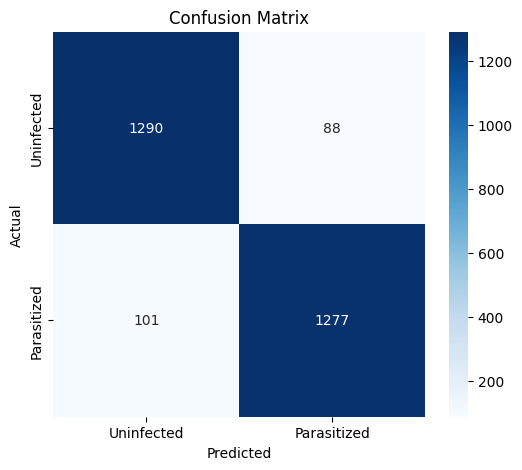

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Put model in eval mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. Accuracy, precision, recall, f1
print(classification_report(all_labels, all_preds, target_names=["Uninfected", "Parasitized"]))

# 2. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Uninfected", "Parasitized"], yticklabels=["Uninfected", "Parasitized"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Gradio Deployment

In [2]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 34.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 102.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
from huggingface_hub import hf_hub_download
import torch
from torchvision import models, transforms
from PIL import Image
import gradio as gr


repo_id = "Xviper/efficientnet-malaria-model"  # Replace with your repo
filename = "efficientnet_malaria.pt"  # Replace with your model file
model_path = hf_hub_download(repo_id=repo_id, filename=filename)


efficientnet_malaria.pt:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

In [7]:
import torch
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate EfficientNetB0 with the SAME classifier as during training
model = models.efficientnet_b0(pretrained=False)
in_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(256, 2)  # Malaria (Parasitized/Uninfected)
)

# Load the weights from Hugging Face
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [15]:
import numpy as np

# Label mapping (adjust if you want to swap the labels)
label_map = {0: "Uninfected", 1: "Parasitized"}

def predict(image):
    # Convert numpy array to PIL Image if needed
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    
    if image.mode != "RGB":
        image = image.convert("RGB")
    
    # Apply transformations
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_label = label_map[predicted.item()]
    return predicted_label

In [16]:
import gradio as gr

iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="Malaria Detection with EfficientNet",
    description="Upload a blood smear image to detect malaria."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7863
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://66c5518831ec18eb38.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
